# 2012-01-23

In [1]:
import datetime
import urllib.request

# define riometer readfile function
def rio_readfile(url):

    # Define lists
    #date = [] #do i even need the date cause it's the same year?
    time = []
    absorption = []
    raw_sig = []

    # Define filename
    #filename = "RD 2012-03-03.txt"

    # open file to read
    response = urllib.request.urlopen(url)
    html_response = response.read()
    encoding = response.headers.get_content_charset("utf-8")
    fp = html_response.decode(encoding)

    # define new list sanitized_data
    # entry = [] list defined later, append datetime, absp, raw sig to it
    # later append entry to sanitized_data so it will be lists within a list
    sanitized_data = []
    
    for line in fp.splitlines():
        #print(line)
        #print(str(line))
    
        # skip comments
        if line[0] == "#":
            continue
        else:
            
            # strip line
            line_strip = line.strip()
            # split lines into lists
            line_split = line.split()
            #print(line_split[1])

            # Define datetime format for date and time
            
            format = "%d%m%Y%H:%M:%S"
            
            # split column 0 to month, date, year and make one row
            month = str(line_split[0].split("/")[1])
            day = str(line_split[0].split("/")[0])
            year = "20" + str(line_split[0].split("/")[2])
                      
            # change this to dd mm yy!!!!!!!!!!!
            full_date = day + month + year + str(line_split[1])
            
            # Try-except to see if can convert to datetime
            try:
                res = bool(datetime.datetime.strptime(full_date, format))
                this_time = datetime.datetime.strptime(full_date, format)

                # Get rid of negative absorption values
                if float(line_split[2]) < 0:
                    continue
                # append time to array
                time.append(this_time)
                # append absorption to array
                absorption.append(float(line_split[2]))
                # append raw signals to array
      
                raw_sig.append(line_split[3])

                # define new list 
                entry = []
                entry.append(this_time)
                entry.append(line_split[2])
                entry.append(line_split[3])
                
                sanitized_data.append(entry)
                    
            except ValueError:
                res = False

    #return sanitized_data
    return sanitized_data, time, absorption, raw_sig
    #return absorption
    #return raw_sig

In [2]:
## Import stuff
import numpy as np

def ionosonde_plotter(f):
    # Define timestamp array
    timestamp_full = []

    # Minimum virtual height of E trace
    sanitized_hE = []
    # Minimum virtual height of Es trace
    sanitized_hEs = []
    # Define CS array
    CS = []

    # E layer critical frequency
    sanitized_foE = []
    # Es layer critical frequency
    sanitized_foEs = []


    # Define filename
    filename = f + ".txt"

    # define indices for each parameter of file
    time_idx = 0
    CS_idx = 1
    foEs_idx = 2
    foE_idx = 4
    hE_idx = 6
    hEs_idx = 8

    # Define format for datetime
    format = "%Y-%m-%dT%H:%M:%S.%fZ"

    # Open file - read
    fp = open(filename, 'r')
    # Read every line in file
    for line in fp:
    # Skip comments
        if line[0] == "#":
            continue
    # Strip lines
        else:
            line_strip = line.strip()
    # Split lines into lists
            line_split = line.split()

            foE_str = line_split[foE_idx]
            foEs_str = line_split[foEs_idx]
            hE_str = line_split[hE_idx]
            hEs_str = line_split[hEs_idx]

            timestamp_full.append(datetime.datetime.strptime(line_split[time_idx], format))

            # Check if can convert foE to float
            try:
                foE_float = float(foE_str)
                # Extract timestamp and append to the array
                timestamp_str = line_split[time_idx]
                timestamp_datetime = datetime.datetime.strptime(timestamp_str, format)
                sanitized_foE.append([timestamp_datetime, foE_float])
            except ValueError:
                # If the conversion fails, ignore the line
                pass

            # Check if can convert foEs to float
            try:
                foEs_float = float(foEs_str)
                # Extract timestamp and append to the array
                timestamp_str = line_split[time_idx]
                timestamp_datetime = datetime.datetime.strptime(timestamp_str, format)
                sanitized_foEs.append([timestamp_datetime, foEs_float])
            except ValueError:
                # If the conversion fails, ignore the line
                pass

            # Check if hE can convert to float
            try:
                hE_float = float(hE_str)
                # Extract timestamp and append to the array
                timestamp_str = line_split[time_idx]
                timestamp_datetime = datetime.datetime.strptime(timestamp_str, format)
                sanitized_hE.append([timestamp_datetime, hE_float])
            except ValueError:
                # If the conversion fails, ignore the line
                pass

            # Check if hEs can convert to float
            try:
                hEs_float = float(hEs_str)
                # Extract timestamp and append to the array
                timestamp_str = line_split[time_idx]
                timestamp_datetime = datetime.datetime.strptime(timestamp_str, format)
                sanitized_hEs.append([timestamp_datetime, hEs_float])
            except ValueError:
                # If the conversion fails, ignore the line
                pass

    return sanitized_hEs, sanitized_foEs


In [3]:
# call rio readfile on 2012/03/08 riometer file
url = "https://data.phys.ucalgary.ca/sort_by_project/GO-Canada/GO-Rio/txt/2012/01/23/norstar_k2_rio-daws_20120123_v01.txt"

sanitized_data, time, absorption, raw_sig = rio_readfile(url)

In [7]:
# call ionosonde readfile on 2012-03-08
f = "2012-01-23"

sanitized_hEs, sanitized_foEs = ionosonde_plotter(f)

In [8]:
import math
current_hour = None

measurement_count = 0 # keep track of absorption count per hour
absorption_total = None # keep track of absorption sum per hour
current_max = None # to check peak abs value for that hour

avg_absorption_list = [] # the hour, avg abs for that hour, peak abs
avg_absorption_only = []

# go through every list in sanitized data
for measurement in sanitized_data:
    if current_hour == None: # for the first ever list being read. Sets current hour
        current_hour = int(measurement[0].hour)
    if int(measurement[0].hour) == current_hour: # if hour in list == hour we're looking at. separates each hour
        try:
            absorption_value = float(measurement[1])
            if not math.isnan(absorption_value): # because NaN values get converted to math.isnan or something
                if not current_max: # because first max of an hour is None so set that to max between absorptionval and 0
                    current_max = max(absorption_value,0)
                else:
                    current_max = max(absorption_value, current_max)
                if not absorption_total: # absorption total can be NOne
                    absorption_total = absorption_value
                else:
                    absorption_total += absorption_value

        except ValueError:
            pass
        measurement_count += 1
    else: # when the end of one hour comes
        if absorption_total: # if condition only if absorption value is not still None
            # append values of the hour we're looking at
            avg_absorption_list.append([current_hour, absorption_total/measurement_count, current_max])
            #avg_absorption_only.append(absorption_total/measurement_count)
        current_hour = int(measurement[0].hour) # set new hour
        # do the same absorption stuff again
        try:
            if not math.isnan(float(measurement[1])):
                absorption_total = float(measurement[1])
                measurement_count = 1
        except ValueError:
            measurement_count = 0
            absorption_total = None

if absorption_total:
    avg_absorption_list.append([current_hour, absorption_total/measurement_count, current_max])
    #avg_absorption_only.append(absorption_total/measurement_count)


In [9]:
# define function to get points per hour for hEs and foEs
def number_of_points(sanitized_data_var):
    points_per_hour = [] # list that gets returned
    current_hour = None
    points_count = 0 # points count

    for measurement in sanitized_data_var:
        if current_hour == None: # sets first ever list hour
            current_hour = int(measurement[0].hour)
        if int(measurement[0].hour) == current_hour: # separates each hour
            try:
                var_float = float(measurement[1])
                points_count += 1 # add to number of points per hour count for that hour
            except ValueError:
                continue
        else: # when moving on to the next hour
            points_per_hour.append([current_hour, points_count]) # append last hour's data to pph list
            current_hour = int(measurement[0].hour) # set new hour
            try:
                var_float = float(measurement[1])
                points_count = 1 # set count to 1 because we're in the next hour's first list
            except ValueError:
                continue
    if points_count >= 1: # checks last ever hour
        points_per_hour.append([current_hour, points_count])
    
    return points_per_hour

In [10]:
points_per_hour_foEs = number_of_points(sanitized_foEs)
print(points_per_hour_foEs, "length: ", len(points_per_hour_foEs))
print("\n")
points_per_hour_hEs = number_of_points(sanitized_hEs)
print(points_per_hour_hEs, "length: ", len(points_per_hour_hEs))

[[0, 2], [1, 2], [2, 8], [3, 5], [4, 5], [5, 8], [6, 8], [7, 7], [8, 4], [9, 3], [10, 3], [11, 4], [12, 4], [13, 4], [14, 4], [15, 4], [16, 2], [17, 4], [18, 2], [19, 2], [20, 3], [21, 3], [22, 5], [23, 3]] length:  24


[[0, 2], [1, 2], [2, 8], [3, 5], [4, 5], [5, 8], [6, 8], [7, 7], [8, 4], [9, 3], [10, 3], [11, 4], [12, 4], [13, 4], [14, 4], [15, 4], [16, 2], [17, 4], [18, 2], [19, 2], [20, 3], [21, 3], [22, 5], [23, 3]] length:  24


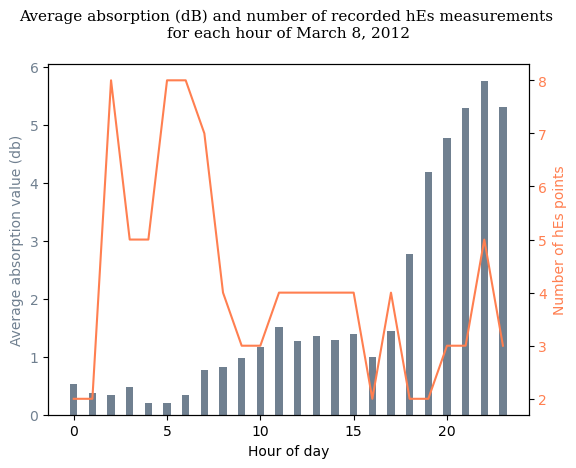

In [11]:
import matplotlib.pyplot as plt

avg_absorption_only = [item[1] for item in avg_absorption_list]
points_only_hEs = [item[1] for item in points_per_hour_hEs]

hours = []
for i in range(0,24):
    hours.append(i)

# need to plot one common hours x axis and two different y axes of absorption avg and hEs point number

fig, ax1 = plt.subplots()

color = 'slategrey'
ax1.set_xlabel("Hour of day")
ax1.set_ylabel("Average absorption value (db)", color=color)
ax1.bar(hours, avg_absorption_only, color=color, width= 0.4)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'coral'
ax2.set_ylabel("Number of hEs points", color = color)
ax2.plot(hours, points_only_hEs, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.tight_layout(pad=3.0)
plt.title("Average absorption (dB) and number of recorded hEs measurements \nfor each hour of March 8, 2012", fontdict={'family': 'serif', 'size': 11}, pad=20)
plt.savefig(" bar - 2012-03-08.png", bbox_inches = 'tight')
plt.show()

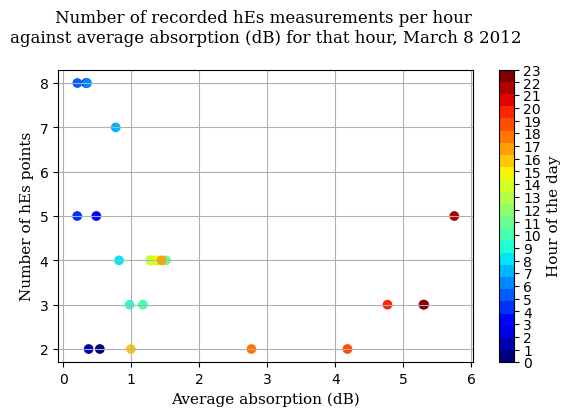

In [12]:
# I have:
### hours list, avg_absorption_only, points_only_hEs
from matplotlib.colors import ListedColormap
import numpy as np

colors = np.linspace(0, 1, 24)

cmap = ListedColormap([plt.cm.jet(color) for color in colors])

scatter = plt.scatter(avg_absorption_only, points_only_hEs, c=hours, cmap=cmap)

plt.xlabel("Average absorption (dB)", fontdict={'family': 'serif', 'size': 11})
plt.ylabel("Number of hEs points", fontdict={'family': 'serif', 'size': 11})
plt.title("Number of recorded hEs measurements per hour \nagainst average absorption (dB) for that hour, March 8 2012", fontdict={'family': 'serif', 'size': 12}, pad=20)

cbar = plt.colorbar(scatter, ticks=np.arange(24))
cbar.set_label('Hour of the day', fontdict={'family': 'serif', 'size': 11})

plt.grid(True)
plt.tight_layout(pad=3.0)
plt.savefig("scatter - 2012-03-08.png")
plt.show()